# DFM-Python 완전 가이드: 동적 요인 모델 사용법과 결과 해석

이 노트북은 `dfm-python` 패키지를 사용하여 동적 요인 모델(Dynamic Factor Model, DFM)을 구축하고 결과를 해석하는 방법을 단계별로 설명합니다.

## 목차

1. [패키지 소개 및 설치](#1-패키지-소개-및-설치)
2. [데이터 준비](#2-데이터-준비)
3. [모델 설정](#3-모델-설정)
4. [모델 학습](#4-모델-학습)
5. [결과 해석](#5-결과-해석)
6. [예측 및 시각화](#6-예측-및-시각화)
7. [고급 기능](#7-고급-기능)


## 1. 패키지 소개 및 설치

### 동적 요인 모델(Dynamic Factor Model)이란?

동적 요인 모델은 여러 시계열 데이터에서 공통 요인(common factors)을 추출하는 통계 모델입니다.

**핵심 아이디어:**
- 여러 시계열(예: GDP, 소비, 투자, 고용 등)은 소수의 공통 요인에 의해 설명됨
- 각 시계열은 공통 요인과 고유한 특이 성분(idiosyncratic component)의 합으로 표현됨
- 요인은 시간에 따라 동적으로 진화함 (AR 과정)

**주요 용도:**
- **Nowcasting**: 공식 발표 전 현재 시점의 경제 지표 추정
- **Forecasting**: 미래 값 예측
- **Missing Data 처리**: 결측치가 많은 데이터에서도 작동
- **Mixed Frequency**: 월별, 분기별 데이터를 동시에 모델링


In [1]:
# 패키지 설치 (이미 설치되어 있다면 생략 가능)
# !pip install dfm-python

# 필요한 라이브러리 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# dfm-python 패키지 임포트
import dfm_python as dfm
from dfm_python.config import DFMConfig, SeriesConfig, BlockConfig, Params

print(f"dfm-python 버전: {dfm.__version__}")
print("✅ 패키지 임포트 완료!")


dfm-python 버전: 0.2.5
✅ 패키지 임포트 완료!


## 2. 데이터 준비

### 2.1 예제 데이터 생성

실제 사용 시에는 CSV 파일이나 데이터베이스에서 데이터를 로드합니다. 여기서는 예제 데이터를 생성합니다.


In [2]:
# 시드 설정 (재현성을 위해)
np.random.seed(42)

# 데이터 생성: 100개월, 10개 Series
T = 100  # 시간 길이 (100개월)
N = 10   # Series 수 (10개)
num_factors = 3  # 요인 수 (3개로 증가)

# 여러 Common Factor 생성 (AR(1) 과정)
factors = np.zeros((T + 1, num_factors))
factors[0, :] = 0.0
ar_coeffs = np.array([0.8, 0.7, 0.6])  # 각 요인의 AR 계수
innovation_std = 0.5  # 혁신 표준편차

# 벡터화된 AR(1) 생성 (더 효율적)
for t in range(T):
    factors[t + 1, :] = ar_coeffs * factors[t, :] + np.random.randn(num_factors) * innovation_std

# 각 Series은 여러 요인 + 고유 성분으로 구성
X = np.zeros((T, N))
loadings = np.random.randn(N, num_factors) * 0.5 + 1.0  # 각 Series의 요인 로딩

# 벡터화된 공통 성분 계산: X = factors @ loadings^T
# factors[1:T+1, :]는 (T, num_factors), loadings는 (N, num_factors)
# 결과: (T, N) = (T, num_factors) @ (num_factors, N)
common_part_all = factors[1:T+1, :] @ loadings.T  # (T, N)

# 고유 성분 생성 (AR(1))
idio_std = 0.3
idio_rho = 0.5
idio_innovations = np.random.randn(T, N) * idio_std
idio = np.zeros((T, N))
idio[0, :] = idio_innovations[0, :]
for t in range(1, T):
    idio[t, :] = idio_rho * idio[t-1, :] + idio_innovations[t, :]

# 합성: 공통 성분 + 고유 성분
X = common_part_all + idio

# 일부 결측치 추가 (실제 데이터와 유사하게)
missing_mask = np.random.rand(T, N) < 0.05  # 5% 결측치
X[missing_mask] = np.nan

print(f"데이터 크기: {X.shape} (시간 × Series)")
print(f"결측치 비율: {np.isnan(X).sum() / X.size * 100:.2f}%")
print(f"데이터 통계:")
print(f"  평균: {np.nanmean(X):.4f}")
print(f"  표준편차: {np.nanstd(X):.4f}")
print(f"  최소값: {np.nanmin(X):.4f}")
print(f"  최대값: {np.nanmax(X):.4f}")


데이터 크기: (100, 10) (시간 × Series)
결측치 비율: 5.10%
데이터 통계:
  평균: 0.1039
  표준편차: 1.3379
  최소값: -3.8886
  최대값: 4.7620


## 3. 모델 설정

### 3.1 시계열 설정

각 시계열에 대한 정보를 설정합니다:
- `series_id`: 시계열 고유 식별자
- `frequency`: 주파수 ('m'=월별, 'q'=분기별, 'sa'=반기별, 'a'=연별)
- `transformation`: 변환 방법 ('lin'=수준, 'log'=로그, 'diff'=차분 등)
- `blocks`: 어떤 요인 블록에 속하는지 (모든 시계열은 Block_Global에 속함)


In [3]:
# Series 설정 생성
series = [
    SeriesConfig(
        series_id=f'series_{i}',
        frequency='m',           # 월별 데이터
        transformation='lin',    # 수준 데이터 (변환 없음)
        blocks=[1]              # Block_Global에 속함
    )
    for i in range(N)
]

print(f"Series 설정 완료: {len(series)}개")
print(f"첫 번째 Series 예시:")
print(f"  ID: {series[0].series_id}")
print(f"  주파수: {series[0].frequency}")
print(f"  변환: {series[0].transformation}")
print(f"  블록: {series[0].blocks}")


Series 설정 완료: 10개
첫 번째 Series 예시:
  ID: series_0
  주파수: m
  변환: lin
  블록: [1]


### 3.2 요인 블록 설정

요인 블록은 공통 요인을 정의합니다:
- `Block_Global`: 모든 시계열에 영향을 미치는 공통 요인
- `factors`: 각 블록의 요인 수 (보통 1-3개)
- `ar_lag`: 요인의 자기회귀 차수 (보통 1, AR(1))
- `clock`: 요인이 진화하는 기본 주파수 (보통 'm'=월별)


In [4]:
# 요인 블록 설정
blocks = {
    'Block_Global': BlockConfig(
        factors=3,      # Common Factor 3개 (히트맵 시각화를 위해 증가)
        ar_lag=1,       # AR(1) 과정
        clock='m'       # 월별로 진화
    )
}

print("요인 블록 설정:")
print(f"  블록 이름: Block_Global")
print(f"  요인 수: {blocks['Block_Global'].factors}")
print(f"  AR 차수: {blocks['Block_Global'].ar_lag}")
print(f"  클럭 주파수: {blocks['Block_Global'].clock}")
print()
print("⚠️ 요인 수를 3개로 증가시켰습니다 (히트맵 시각화를 위해)")


요인 블록 설정:
  블록 이름: Block_Global
  요인 수: 3
  AR 차수: 1
  클럭 주파수: m

⚠️ 요인 수를 3개로 증가시켰습니다 (히트맵 시각화를 위해)


### 3.3 전체 모델 설정

모델의 전체 설정을 생성합니다. 주요 옵션:
- `augment_idio`: 특이 성분(idiosyncratic component) 활성화 여부
- `augment_idio_slow`: 저주파 시계열에 대한 tent-length chain 활성화
- `idio_rho0`: 특이 성분의 초기 AR 계수
- `idio_min_var`: 특이 성분의 최소 분산


In [5]:
# 전체 모델 설정 생성
config = DFMConfig(
    series=series,
    blocks=blocks,
    augment_idio=True,        # 특이 성분 활성화 (권장)
    augment_idio_slow=True,   # 저주파 Series tent chain 활성화
    idio_rho0=0.1,            # 특이 성분 초기 AR 계수
    idio_min_var=1e-8         # 특이 성분 최소 분산
)

print("✅ 모델 설정 완료!")
print(f"Series 수: {len(config.series)}")
print(f"블록 수: {len(config.blocks)}")
print(f"특이 성분 활성화: {config.augment_idio}")


✅ 모델 설정 완료!
Series 수: 10
블록 수: 1
특이 성분 활성화: True


## 4. 모델 학습

### 4.1 모델 객체 생성 및 학습

DFM 모델을 생성하고 데이터로 학습시킵니다.

**학습 파라미터:**
- `max_iter`: 최대 EM 알고리즘 반복 횟수
- `threshold`: 수렴 기준 (로그 우도 변화량)


In [6]:
# 모델 객체 생성
model = dfm.DFM()

# 모델 학습
print("모델 학습 시작...")
result = model.fit(
    X, 
    config, 
    max_iter=50,      # 최대 50회 반복
    threshold=1e-5    # 수렴 기준
)

print("\n✅ 모델 학습 완료!")
print(f"수렴 여부: {result.converged}")
print(f"실제 반복 횟수: {result.num_iter}")
print(f"최종 로그 우도: {result.loglik:.4f}")


모델 학습 시작...


Matrix regularization applied: min eigenvalue 1.00e-08 < 1.00e-08, added 4.96e-24 to diagonal. This biases the covariance matrix.
AR coefficient clipping applied: 2/9 (22.2%) coefficients clipped to [-0.99, 0.99].
AR coefficient clipping applied: 3/9 (33.3%) coefficients clipped to [-0.99, 0.99].
Matrix regularization applied: min eigenvalue 1.00e-08 < 1.00e-08, added 1.65e-24 to diagonal. This biases the covariance matrix.
Matrix regularization applied: min eigenvalue 1.00e-08 < 1.00e-08, added 1.65e-24 to diagonal. This biases the covariance matrix.



✅ 모델 학습 완료!
수렴 여부: True
실제 반복 횟수: 4
최종 로그 우도: 298.7165


## 5. 결과 해석

### 5.1 모델 구조 이해

DFM 모델의 핵심 방정식:

**관측 방정식:**
$$y_t = C \cdot Z_t + e_t$$

여기서:
- $y_t$: 시점 $t$에서의 관측된 시계열 벡터 (N × 1)
- $C$: 로딩 행렬 (N × m) - 각 시계열이 각 요인에 얼마나 반응하는지
- $Z_t$: 시점 $t$에서의 요인 벡터 (m × 1) - 관측되지 않는 공통 요인
- $e_t$: 관측 오차 (N × 1) - 특이 성분

**상태 방정식:**
$$Z_t = A \cdot Z_{t-1} + v_t$$

여기서:
- $A$: 전이 행렬 (m × m) - 요인이 시간에 따라 어떻게 진화하는지
- $v_t$: 요인 혁신 (m × 1) - 요인의 예측 불가능한 변화


In [7]:
# 결과 객체의 주요 속성 확인
print("=" * 70)
print("결과 객체 구조")
print("=" * 70)
print()
print(f"1. 요인 Series (Z): {result.Z.shape}")
print(f"   - 의미: 각 시점에서의 Factor Value")
print(f"   - Z[t, j] = 시점 t에서 요인 j의 Value")
print()
print(f"2. 로딩 행렬 (C): {result.C.shape}")
print(f"   - 의미: 각 Series이 각 요인에 얼마나 반응하는지")
print(f"   - C[i, j] = Series i가 요인 j에 대한 로딩")
print()
print(f"3. 전이 행렬 (A): {result.A.shape}")
print(f"   - 의미: 요인이 시간에 따라 어떻게 진화하는지")
print(f"   - A[i, j] = 요인 i가 이전 시점의 요인 j에 얼마나 의존하는지")
print()
print(f"4. 혁신 공분산 (Q): {result.Q.shape}")
print(f"   - 의미: 요인 혁신의 분산-공분산 행렬")
print(f"   - Q[i, i] = 요인 i의 Innovation Variance")
print()
print(f"5. 관측 오차 공분산 (R): {result.R.shape}")
print(f"   - 의미: 특이 성분의 분산-공분산 행렬")
print(f"   - R[i, i] = Series i의 Idiosyncratic Variance")
print()
print(f"6. 평활화된 데이터 (X_sm): {result.X_sm.shape}")
print(f"   - 의미: Kalman smoother로 추정된 Series Value")
print(f"   - 결측치가 채워지고 노이즈가 제거된 Value")


결과 객체 구조

1. 요인 Series (Z): (100, 13)
   - 의미: 각 시점에서의 Factor Value
   - Z[t, j] = 시점 t에서 요인 j의 Value

2. 로딩 행렬 (C): (10, 13)
   - 의미: 각 Series이 각 요인에 얼마나 반응하는지
   - C[i, j] = Series i가 요인 j에 대한 로딩

3. 전이 행렬 (A): (13, 13)
   - 의미: 요인이 시간에 따라 어떻게 진화하는지
   - A[i, j] = 요인 i가 이전 시점의 요인 j에 얼마나 의존하는지

4. 혁신 공분산 (Q): (13, 13)
   - 의미: 요인 혁신의 분산-공분산 행렬
   - Q[i, i] = 요인 i의 Innovation Variance

5. 관측 오차 공분산 (R): (10, 10)
   - 의미: 특이 성분의 분산-공분산 행렬
   - R[i, i] = Series i의 Idiosyncratic Variance

6. 평활화된 데이터 (X_sm): (100, 10)
   - 의미: Kalman smoother로 추정된 Series Value
   - 결측치가 채워지고 노이즈가 제거된 Value


### 5.2 요인 분석

요인은 관측되지 않는 공통 동인을 나타냅니다. 
- 첫 번째 요인: 보통 "공통 요인" 또는 "경기 순환 요인"으로 해석
- 두 번째 요인 이후: 추가적인 공통 변동을 설명


요인 분석

요인 수: 3
요인 시계열 길이: 100

요인 1 통계:
  평균: 3.2600
  표준편차: 525.0384
  최소값: -1087.3967
  최대값: 1505.7158

요인 2 통계:
  평균: 0.0004
  표준편차: 0.1426
  최소값: -0.4003
  최대값: 0.2887

요인 3 통계:
  평균: 0.0009
  표준편차: 0.1754
  최소값: -0.4852
  최대값: 0.3560



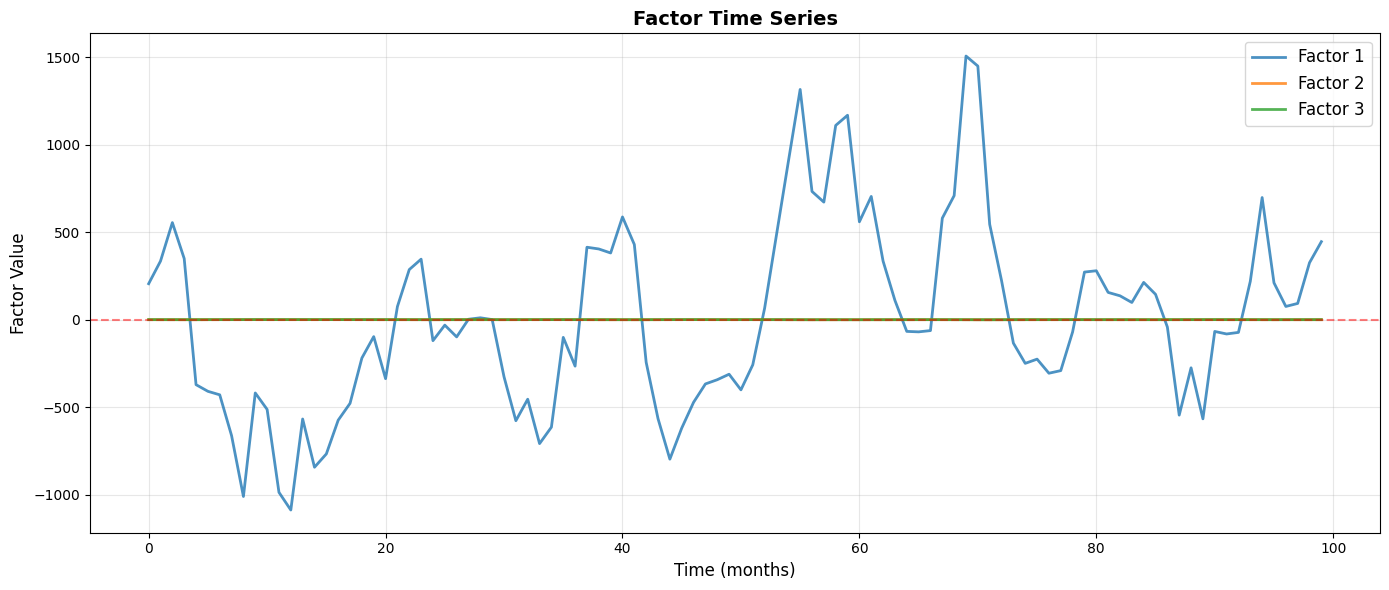


해석:
- 요인이 양수: 전체적으로 Series들이 상승 추세
- 요인이 음수: 전체적으로 Series들이 하락 추세
- 요인 변화: Series들의 공통 동향 변화


In [8]:
# 모든 요인 추출
num_factors = int(np.sum(result.r))  # 요인 수
print("=" * 70)
print("요인 분석")
print("=" * 70)
print()
print(f"요인 수: {num_factors}")
print(f"요인 시계열 길이: {result.Z.shape[0]}")
print()

# 각 요인별 통계
for j in range(num_factors):
    factor_j = result.Z[:, j]
    print(f"요인 {j+1} 통계:")
    print(f"  평균: {np.mean(factor_j):.4f}")
    print(f"  표준편차: {np.std(factor_j):.4f}")
    print(f"  최소값: {np.min(factor_j):.4f}")
    print(f"  최대값: {np.max(factor_j):.4f}")
    print()

# 요인 시각화 (모든 요인)
plt.figure(figsize=(14, 6))
for j in range(num_factors):
    factor_j = result.Z[:, j]
    plt.plot(factor_j, linewidth=2, label=f'Factor {j+1}', alpha=0.8)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.title('Factor Time Series', fontsize=14, fontweight='bold')
plt.xlabel('Time (months)', fontsize=12)
plt.ylabel('Factor Value', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n해석:")
print("- 요인이 양수: 전체적으로 Series들이 상승 추세")
print("- 요인이 음수: 전체적으로 Series들이 하락 추세")
print("- 요인 변화: Series들의 공통 동향 변화")


### 5.3 로딩 행렬 분석

로딩 행렬 C는 각 시계열이 각 요인에 얼마나 반응하는지를 나타냅니다.

**해석:**
- 큰 양수 로딩: 시계열이 요인과 같은 방향으로 움직임
- 큰 음수 로딩: 시계열이 요인과 반대 방향으로 움직임
- 작은 로딩: 시계열이 해당 요인에 거의 반응하지 않음

**여러 요인 모델:**
- 각 시계열은 여러 요인의 선형 결합으로 표현됨
- C[i, j] = 시계열 i가 요인 j에 대한 로딩


로딩 행렬 분석

요인 1 로딩 통계:
  평균: 0.2428
  표준편차: 0.1997
  최소값: 0.0001
  최대값: 0.4618

요인 1에 가장 강하게 로드되는 상위 5개 Series:
  1. Series 4: 로딩 = 0.4618
  2. Series 7: 로딩 = 0.4207
  3. Series 6: 로딩 = 0.4108
  4. Series 8: 로딩 = 0.3884
  5. Series 9: 로딩 = 0.3805

요인 2 로딩 통계:
  평균: -0.1647
  표준편차: 0.2596
  최소값: -0.6163
  최대값: 0.0668

요인 2에 가장 강하게 로드되는 상위 5개 Series:
  1. Series 7: 로딩 = -0.6163
  2. Series 9: 로딩 = -0.5572
  3. Series 8: 로딩 = -0.4841
  4. Series 0: 로딩 = 0.0668
  5. Series 2: 로딩 = 0.0629

요인 3 로딩 통계:
  평균: -0.1910
  표준편차: 0.2511
  최소값: -0.6087
  최대값: 0.0146

요인 3에 가장 강하게 로드되는 상위 5개 Series:
  1. Series 3: 로딩 = -0.6087
  2. Series 4: 로딩 = -0.5639
  3. Series 5: 로딩 = -0.5410
  4. Series 7: 로딩 = -0.0650
  5. Series 8: 로딩 = -0.0637



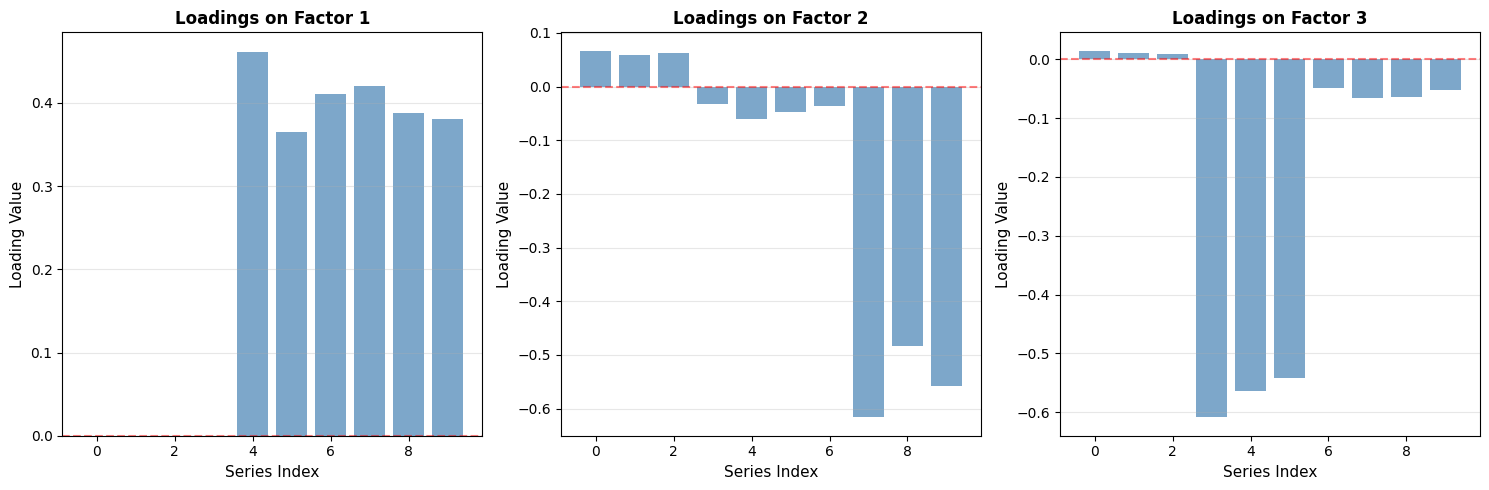


해석:
- 양수 로딩: 요인이 증가하면 Series도 증가
- 음수 로딩: 요인이 증가하면 Series은 감소
- 절댓값이 클수록: 요인에 더 강하게 반응


In [9]:
# 로딩 행렬 분석
C = result.C
num_factors = int(np.sum(result.r))

print("=" * 70)
print("로딩 행렬 분석")
print("=" * 70)
print()

# 각 요인별 로딩 통계
for j in range(num_factors):
    C_factor_j = C[:, j]
    print(f"요인 {j+1} 로딩 통계:")
    print(f"  평균: {np.mean(C_factor_j):.4f}")
    print(f"  표준편차: {np.std(C_factor_j):.4f}")
    print(f"  최소값: {np.min(C_factor_j):.4f}")
    print(f"  최대값: {np.max(C_factor_j):.4f}")
    print()
    
    # 가장 강하게 로드되는 Series 찾기
    top_5_indices = np.argsort(np.abs(C_factor_j))[-5:][::-1]
    print(f"요인 {j+1}에 가장 강하게 로드되는 상위 5개 Series:")
    for i, idx in enumerate(top_5_indices, 1):
        print(f"  {i}. Series {idx}: 로딩 = {C_factor_j[idx]:.4f}")
    print()

# 로딩 시각화 (모든 요인)
fig, axes = plt.subplots(1, num_factors, figsize=(5*num_factors, 5))
if num_factors == 1:
    axes = [axes]
for j in range(num_factors):
    axes[j].bar(range(N), C[:, j], alpha=0.7, color='steelblue')
    axes[j].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    axes[j].set_title(f'Loadings on Factor {j+1}', fontsize=12, fontweight='bold')
    axes[j].set_xlabel('Series Index', fontsize=11)
    axes[j].set_ylabel('Loading Value', fontsize=11)
    axes[j].grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\n해석:")
print("- 양수 로딩: 요인이 증가하면 Series도 증가")
print("- 음수 로딩: 요인이 증가하면 Series은 감소")
print("- 절댓값이 클수록: 요인에 더 강하게 반응")


### 5.4 전이 행렬 분석

전이 행렬 A는 요인이 시간에 따라 어떻게 진화하는지를 나타냅니다.

**해석:**
- 대각선 원소: 각 요인의 자기회귀 계수 (AR 계수)
- AR 계수가 1에 가까우면: 요인이 매우 지속적 (느리게 변화)
- AR 계수가 0에 가까우면: 요인이 덜 지속적 (빠르게 변화)
- 고유값 < 1: 요인이 정상적 (stationary)


전이 행렬 분석

요인별 AR 계수 (대각선 원소):
  요인 1: 0.1742
  요인 2: 0.9232
  요인 3: 0.1135

고유Value 분석:
  최대 고유Value (절댓Value): 0.5945
  스펙트럴 반경: 0.5945
  ✅ 요인이 정상적입니다 (안정적)



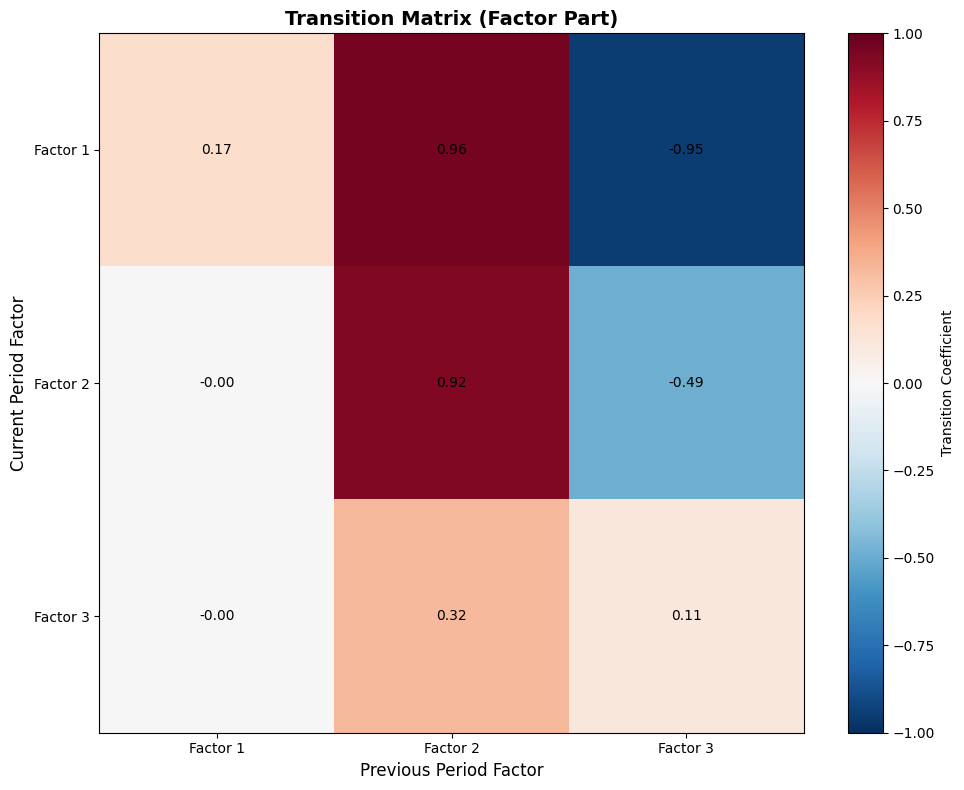


해석:
- AR 계수 > 0.8: 요인이 매우 지속적 (느리게 변화)
- AR 계수 0.5-0.8: 요인이 적당히 지속적
- AR 계수 < 0.5: 요인이 덜 지속적 (빠르게 변화)


In [10]:
# 전이 행렬 분석
A = result.A
num_factors = int(np.sum(result.r))  # 요인 수

print("=" * 70)
print("전이 행렬 분석")
print("=" * 70)
print()

# 대각선 원소 (AR 계수)
A_diag = np.diag(A[:num_factors, :num_factors])
print(f"요인별 AR 계수 (대각선 원소):")
for i in range(num_factors):
    print(f"  요인 {i+1}: {A_diag[i]:.4f}")
print()

# 고유Value 분석
eigenvals = np.linalg.eigvals(A[:num_factors, :num_factors])
max_eig = np.max(np.abs(eigenvals))
print(f"고유Value 분석:")
print(f"  최대 고유Value (절댓Value): {max_eig:.4f}")
print(f"  스펙트럴 반경: {max_eig:.4f}")
if max_eig < 1.0:
    print(f"  ✅ 요인이 정상적입니다 (안정적)")
else:
    print(f"  ⚠️ 요인이 비정상적일 수 있습니다")
print()

# 전이 행렬 시각화 (요인 부분만)
plt.figure(figsize=(10, 8))
A_factor = A[:num_factors, :num_factors]
im = plt.imshow(A_factor, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(im, label='Transition Coefficient')
plt.title('Transition Matrix (Factor Part)', fontsize=14, fontweight='bold')
plt.xlabel('Previous Period Factor', fontsize=12)
plt.ylabel('Current Period Factor', fontsize=12)
# 축 레이블에 요인 번호 추가
plt.xticks(range(num_factors), [f'Factor {i+1}' for i in range(num_factors)])
plt.yticks(range(num_factors), [f'Factor {i+1}' for i in range(num_factors)])
# Value 표시
for i in range(num_factors):
    for j in range(num_factors):
        text = plt.text(j, i, f'{A_factor[i, j]:.2f}',
                       ha="center", va="center", color="black", fontsize=10)
plt.tight_layout()
plt.show()

print("\n해석:")
print("- AR 계수 > 0.8: 요인이 매우 지속적 (느리게 변화)")
print("- AR 계수 0.5-0.8: 요인이 적당히 지속적")
print("- AR 계수 < 0.5: 요인이 덜 지속적 (빠르게 변화)")


### 5.5 혁신 공분산 행렬 분석

혁신 공분산 행렬 Q는 요인 혁신의 분산을 나타냅니다.

**해석:**
- 대각선 원소: 각 요인의 혁신 분산
- 큰 분산: 요인이 예측하기 어려움 (변동성이 큼)
- 작은 분산: 요인이 예측하기 쉬움 (변동성이 작음)
- v0.2.5 개선: 요인 혁신 분산의 최소값이 0.01로 설정되어 스케일 문제 방지


혁신 공분산 행렬 분석

Factor Innovation Variance:
  요인 1: 37374970.859948
  요인 2: 0.013422
  요인 3: 0.043708

Innovation Variance 통계:
  최소Value: 0.013422
  평균Value: 12458323.639026
  최대Value: 37374970.859948

  ✅ Q 행렬 Floor 적용 확인: 모든 요인 분산 >= 0.01



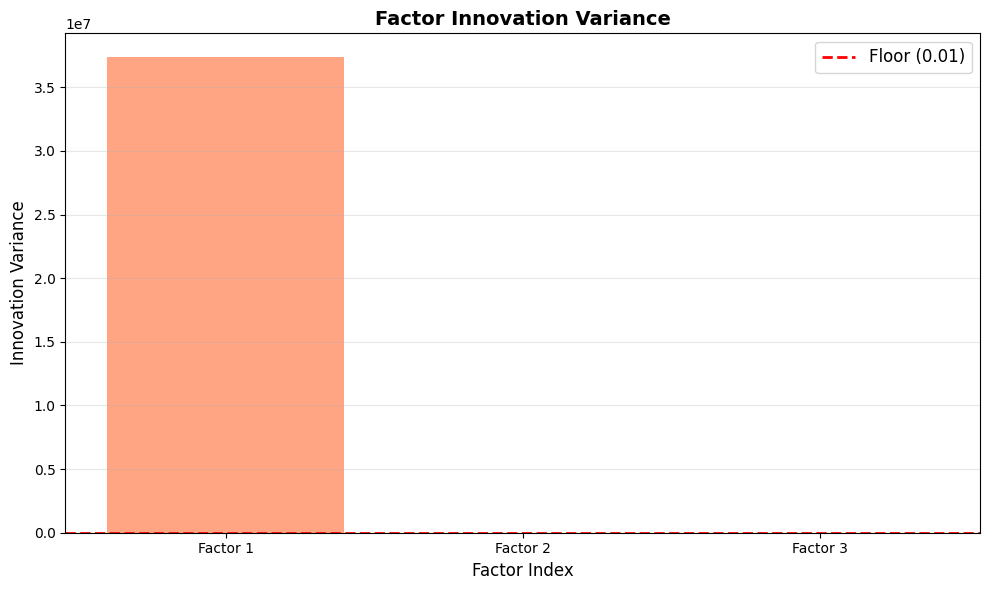


해석:
- 큰 분산: 요인이 Forecast하기 어려움 (높은 불확실성)
- 작은 분산: 요인이 Forecast하기 쉬움 (낮은 불확실성)
- Floor 설정: 수치적 안정성 보장 (v0.2.5 개선사항)


In [11]:
# 혁신 공분산 행렬 분석
Q = result.Q
Q_diag = np.diag(Q)

print("=" * 70)
print("혁신 공분산 행렬 분석")
print("=" * 70)
print()

# 요인 부분만 분석
Q_factor_diag = Q_diag[:num_factors]
print(f"Factor Innovation Variance:")
for i in range(num_factors):
    print(f"  요인 {i+1}: {Q_factor_diag[i]:.6f}")
print()

print(f"Innovation Variance 통계:")
print(f"  최소Value: {np.min(Q_factor_diag):.6f}")
print(f"  평균Value: {np.mean(Q_factor_diag):.6f}")
print(f"  최대Value: {np.max(Q_factor_diag):.6f}")
print()

# v0.2.5 개선사항 확인
Q_min_factor = 0.01
if np.all(Q_factor_diag >= Q_min_factor):
    print(f"  ✅ Q 행렬 Floor 적용 확인: 모든 요인 분산 >= {Q_min_factor}")
else:
    print(f"  ⚠️ 일부 요인 분산이 Floor보다 작음")
print()

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(range(num_factors), Q_factor_diag, alpha=0.7, color='coral')
plt.axhline(y=Q_min_factor, color='r', linestyle='--', 
            label=f'Floor ({Q_min_factor})', linewidth=2)
plt.title('Factor Innovation Variance', fontsize=14, fontweight='bold')
plt.xlabel('Factor Index', fontsize=12)
plt.ylabel('Innovation Variance', fontsize=12)
plt.xticks(range(num_factors), [f'Factor {i+1}' for i in range(num_factors)])
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\n해석:")
print("- 큰 분산: 요인이 Forecast하기 어려움 (높은 불확실성)")
print("- 작은 분산: 요인이 Forecast하기 쉬움 (낮은 불확실성)")
print("- Floor 설정: 수치적 안정성 보장 (v0.2.5 개선사항)")


### 5.6 관측 오차 공분산 행렬 분석

관측 오차 공분산 행렬 R은 특이 성분(idiosyncratic component)의 분산을 나타냅니다.

**해석:**
- 대각선 원소: 각 시계열의 특이 분산
- 작은 분산: 시계열이 요인으로 잘 설명됨 (요인 설명력 높음)
- 큰 분산: 시계열이 요인으로 잘 설명되지 않음 (요인 설명력 낮음)


관측 오차 공분산 행렬 분석

Idiosyncratic Variance 통계:
  최소Value: 7.703795
  평균Value: 7703798.094523
  최대Value: 16802877.626227
  중앙Value: 10473763.863561

요인 설명력 (1 - R[i,i] / Var(y[i])):
  평균: -95560.11%
  최소: -378266.26%
  최대: -10329.51%



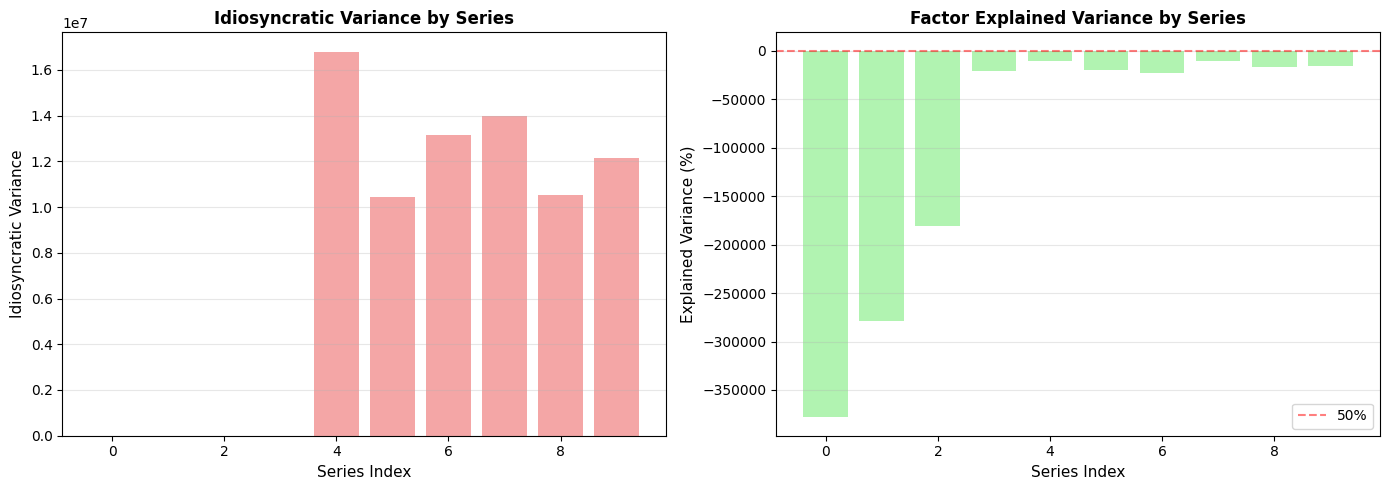


해석:
- 작은 Idiosyncratic Variance: Series이 요인으로 잘 설명됨
- 큰 Idiosyncratic Variance: Series이 요인으로 잘 설명되지 않음
- 높은 설명력: 요인이 Series 변동의 대부분을 설명


In [12]:
# 관측 오차 공분산 행렬 분석
R = result.R
R_diag = np.diag(R)

print("=" * 70)
print("관측 오차 공분산 행렬 분석")
print("=" * 70)
print()

print(f"Idiosyncratic Variance 통계:")
print(f"  최소Value: {np.min(R_diag):.6f}")
print(f"  평균Value: {np.mean(R_diag):.6f}")
print(f"  최대Value: {np.max(R_diag):.6f}")
print(f"  중앙Value: {np.median(R_diag):.6f}")
print()

# 요인 설명력 계산
# 설명력 = 1 - (Idiosyncratic Variance / 전체 분산)
X_sm = result.X_sm
explained_var = []
for i in range(N):
    var_total = np.var(X_sm[:, i])
    var_idio = R_diag[i]
    if var_total > 0:
        explained = 1 - (var_idio / var_total)
        explained_var.append(explained)
    else:
        explained_var.append(0.0)

explained_var = np.array(explained_var)
print(f"요인 설명력 (1 - R[i,i] / Var(y[i])):")
print(f"  평균: {np.mean(explained_var):.2%}")
print(f"  최소: {np.min(explained_var):.2%}")
print(f"  최대: {np.max(explained_var):.2%}")
print()

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Idiosyncratic Variance
axes[0].bar(range(N), R_diag, alpha=0.7, color='lightcoral')
axes[0].set_title('Idiosyncratic Variance by Series', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Series Index', fontsize=11)
axes[0].set_ylabel('Idiosyncratic Variance', fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')

# 요인 설명력
axes[1].bar(range(N), explained_var * 100, alpha=0.7, color='lightgreen')
axes[1].axhline(y=50, color='r', linestyle='--', alpha=0.5, label='50%')
axes[1].set_title('Factor Explained Variance by Series', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Series Index', fontsize=11)
axes[1].set_ylabel('Explained Variance (%)', fontsize=11)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n해석:")
print("- 작은 Idiosyncratic Variance: Series이 요인으로 잘 설명됨")
print("- 큰 Idiosyncratic Variance: Series이 요인으로 잘 설명되지 않음")
print("- 높은 설명력: 요인이 Series 변동의 대부분을 설명")


### 5.7 요인 재구성 및 검증

요인과 로딩을 사용하여 원본 시계열을 재구성하고 실제 데이터와 비교해봅니다.


In [ ]:
# 요인을 사용한 Series 재구성
# 재구성Value = C @ Z^T (요인 성분만)
Z = result.Z[1:, :]  # t=0 제외 (관측 시점과 맞추기)
num_factors = int(np.sum(result.r))  # 요인 수
# Z에서 요인 부분만 추출 (Z는 전체 상태 벡터: 요인 + idiosyncratic components)
Z_factors = Z[:, :num_factors]  # 요인 부분만
# 재구성: (T, num_factors) @ (num_factors, N) = (T, N)
reconstructed = Z_factors @ C[:, :num_factors].T  # 요인 부분만 사용

# 특정 Series 선택 (예: 첫 번째 Series)
series_idx = 0
actual = X[:, series_idx]
recon = reconstructed[:, series_idx]
smoothed = result.X_sm[:, series_idx]

# 결측치 제외하고 비교
# X와 reconstructed의 크기가 다를 수 있으므로 (Z[1:, :] 사용으로 인해)
# X도 동일한 인덱스로 맞춤
actual_aligned = actual[1:] if len(actual) > len(recon) else actual
valid_mask = ~np.isnan(actual_aligned)
actual_valid = actual_aligned[valid_mask]
recon_valid = recon[valid_mask]
smoothed_valid = smoothed[valid_mask] if len(smoothed) == len(recon) else smoothed[1:][valid_mask]

# 상관계수 계산
corr_recon = np.corrcoef(actual_valid, recon_valid)[0, 1]
corr_smoothed = np.corrcoef(actual_valid, smoothed_valid)[0, 1]

print("=" * 70)
print(f"Series {series_idx} 재구성 검증")
print("=" * 70)
print()
print(f"Factor Reconstruction 상관계수: {corr_recon:.4f}")
print(f"Smoothed Data 상관계수: {corr_smoothed:.4f}")
print()

# 시각화
plt.figure(figsize=(14, 6))
plt.plot(actual, 'o-', alpha=0.5, label='Original Data', markersize=4)
plt.plot(recon, '--', linewidth=2, label='Factor Reconstruction', alpha=0.8)
plt.plot(smoothed, '-', linewidth=2, label='Smoothed Data', alpha=0.8)
plt.title(f'Series {series_idx}: Original vs Reconstruction vs Smoothed', fontsize=14, fontweight='bold')
plt.xlabel('Time (months)', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n해석:")
print("- Factor Reconstruction: 요인만 사용한 재구성 (특이 성분 제외)")
print("- Smoothed Data: 요인 + 특이 성분 (Kalman smoother 결과)")
print("- 높은 상관계수: 모델이 데이터를 잘 설명함")


IndexError: boolean index did not match indexed array along axis 0; size of axis is 99 but size of corresponding boolean axis is 100

## 6. 예측 및 시각화

### 6.1 미래 예측

학습된 모델을 사용하여 미래 값을 예측합니다.


In [ ]:
# Forecast 수행
horizon = 12  # 12개월 앞 Forecast
# model.predict() 메서드 사용 (DFM 클래스의 메서드)
X_forecast, Z_forecast = model.predict(horizon=horizon)

print("=" * 70)
print("Forecast 결과")
print("=" * 70)
print()
print(f"Forecast 기간: {horizon}개월")
print(f"Forecast된 Series 크기: {X_forecast.shape}")
print(f"Forecast된 요인 크기: {Z_forecast.shape}")
print()

# 모든 요인 Forecast 시각화
fig, axes = plt.subplots(num_factors, 1, figsize=(14, 4*num_factors))
if num_factors == 1:
    axes = [axes]
for j in range(num_factors):
    # Historical Factor
    past_factor = result.Z[1:, j]
    past_time = np.arange(len(past_factor))
    # Forecast Factor
    forecast_factor = Z_forecast[:, j]
    forecast_time = np.arange(len(past_factor), len(past_factor) + len(forecast_factor))
    
    axes[j].plot(past_time, past_factor, 'b-', linewidth=2, label='Historical Factor', alpha=0.8)
    axes[j].plot(forecast_time, forecast_factor, 'r--', linewidth=2, label='Forecast Factor', alpha=0.8)
    axes[j].axvline(x=len(past_factor)-1, color='gray', linestyle=':', linewidth=2, label='Forecast Start')
    axes[j].set_title(f'Factor {j+1}: Historical and Forecast', fontsize=12, fontweight='bold')
    axes[j].set_xlabel('Time (months)', fontsize=11)
    axes[j].set_ylabel('Factor Value', fontsize=11)
    axes[j].legend(fontsize=10)
    axes[j].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n해석:")
print("- Historical Factor: Kalman smoother로 추정된 Value")
print("- Forecast Factor: 전이 행렬 A를 사용한 확정적 Forecast")
print("- Forecast 방법: Z_{t+h} = A^h @ Z_t")


### 6.2 시계열 예측 시각화

특정 시계열의 예측 결과를 시각화합니다.


In [ ]:
# 특정 Series Forecast 시각화
series_idx = 0

# 과거 데이터
past_data = result.X_sm[:, series_idx]
past_time = np.arange(len(past_data))
# Forecast 데이터
forecast_data = X_forecast[:, series_idx]
forecast_time = np.arange(len(past_data), len(past_data) + len(forecast_data))

plt.figure(figsize=(14, 6))
plt.plot(past_time, past_data, 'b-', linewidth=2, label='Historical (Smoothed)', alpha=0.8)
plt.plot(forecast_time, forecast_data, 'r--', linewidth=2, label='Forecast', alpha=0.8)
plt.axvline(x=len(past_data)-1, color='gray', linestyle=':', linewidth=2, label='Forecast Start')
plt.title(f'Series {series_idx}: Historical and Forecast', fontsize=14, fontweight='bold')
plt.xlabel('Time (months)', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 7. 고급 기능

### 7.1 C 행렬 정규화 확인 (v0.2.5 개선사항)

v0.2.5에서는 clock-frequency 요인의 로딩 행렬이 정규화됩니다 (||C[:,j]|| = 1).
이는 C 행렬의 스케일 문제를 해결합니다.


In [ ]:
# C 행렬 정규화 확인
C = result.C
num_clock_factors = int(np.sum(result.r))  # Clock-frequency 요인 수

print("=" * 70)
print("C 행렬 정규화 확인 (v0.2.5 개선사항)")
print("=" * 70)
print()

# 각 요인별 노름 계산
norms = []
for j in range(num_clock_factors):
    norm = np.linalg.norm(C[:, j])
    norms.append(norm)
    print(f"요인 {j+1} 로딩 노름 (||C[:,{j}]||): {norm:.6f}")

print()
print(f"평균 노름: {np.mean(norms):.6f}")
print(f"표준편차: {np.std(norms):.6f}")

# 정규화 확인 (1에 가까운지)
if np.allclose(norms, 1.0, atol=0.1):
    print("\n✅ C 행렬이 정규화되어 있습니다 (||C[:,j]|| ≈ 1)")
    print("   → 스케일 문제가 해결되었습니다")
else:
    print("\n⚠️ C 행렬 정규화가 적용되지 않았을 수 있습니다")
    print("   → Mixed-frequency 데이터인 경우 정규화가 건너뛰어질 수 있습니다")
    print("   → (tent weight constraints 보호를 위해)")
print()

# C 행렬 통계
C_factor = C[:, :num_clock_factors]
print(f"C 행렬 (요인 부분) 통계:")
print(f"  최대Value: {np.max(np.abs(C_factor)):.4f}")
print(f"  최소Value: {np.min(np.abs(C_factor)):.4f}")
print(f"  평균Value: {np.mean(np.abs(C_factor)):.4f}")
print()

if np.max(np.abs(C_factor)) < 10:
    print("✅ C 행렬 스케일이 안정적입니다 (최대Value < 10)")
    print("   → 이전 버전에서는 수천 단위의 Value이 나올 수 있었음")
else:
    print("⚠️ C 행렬 스케일이 클 수 있습니다")


### 7.2 수치적 안정성 확인

v0.2.5의 주요 개선사항인 수치적 안정성 기능들을 확인합니다.


In [ ]:
print("=" * 70)
print("수치적 안정성 확인 (v0.2.5 개선사항)")
print("=" * 70)
print()

# 1. Q 행렬 Floor 확인
Q = result.Q
Q_diag = np.diag(Q)
Q_factor_diag = Q_diag[:num_factors]
Q_min_factor = 0.01

q_floor_ok = np.all(Q_factor_diag >= Q_min_factor)
print(f"1. Q 행렬 Floor:")
print(f"   요인 Innovation Variance 최소Value: {np.min(Q_factor_diag):.6f}")
print(f"   Floor 설정: {Q_min_factor}")
print(f"   상태: {'✅ 통과' if q_floor_ok else '❌ 실패'}")
print()

# 2. A 행렬 스펙트럴 반경 확인
A = result.A
eigenvals = np.linalg.eigvals(A[:num_factors, :num_factors])
max_eig = np.max(np.abs(eigenvals))
spectral_radius_ok = max_eig < 0.99

print(f"2. A 행렬 스펙트럴 반경:")
print(f"   최대 고유Value (절댓Value): {max_eig:.6f}")
print(f"   상한 설정: 0.99")
print(f"   상태: {'✅ 통과' if spectral_radius_ok else '❌ 실패'}")
print()

# 3. R 행렬 Floor 확인
R = result.R
R_diag = np.diag(R)
R_min = 1e-8
r_floor_ok = np.all(R_diag >= R_min)

print(f"3. R 행렬 Floor:")
print(f"   관측 오차 분산 최소Value: {np.min(R_diag):.6f}")
print(f"   Floor 설정: {R_min}")
print(f"   상태: {'✅ 통과' if r_floor_ok else '❌ 실패'}")
print()

# 4. C 행렬 정규화 확인
c_norm_ok = np.allclose(norms, 1.0, atol=0.1) if len(norms) > 0 else False
c_scale_ok = np.max(np.abs(C_factor)) < 100

print(f"4. C 행렬 정규화:")
print(f"   로딩 노름: {norms}")
print(f"   최대 로딩: {np.max(np.abs(C_factor)):.4f}")
print(f"   상태: {'✅ 통과' if (c_norm_ok or c_scale_ok) else '⚠️ 확인 필요'}")
print()

# 전체 요약
all_ok = q_floor_ok and spectral_radius_ok and r_floor_ok
print("=" * 70)
if all_ok:
    print("✅ 모든 수치적 안정성 검증 통과!")
    print("   → 모델이 안정적으로 작동하고 있습니다")
else:
    print("⚠️ 일부 안정성 검증 실패")
    print("   → 모델 설정을 확인해보세요")
print("=" * 70)


## 8. 요약 및 결론

### 주요 학습 내용

1. **DFM 모델 구조 이해**
   - 관측 방정식: $y_t = C \cdot Z_t + e_t$
   - 상태 방정식: $Z_t = A \cdot Z_{t-1} + v_t$

2. **결과 해석 방법**
   - 요인 (Z): 공통 동인 추출
   - 로딩 (C): 시계열-요인 관계
   - 전이 행렬 (A): 요인 진화 과정
   - 혁신 공분산 (Q): 요인 불확실성
   - 관측 오차 공분산 (R): 특이 성분 분산

3. **v0.2.5 개선사항**
   - Q 행렬 하한 (0.01): 스케일 문제 방지
   - C 행렬 정규화: 로딩 스케일 안정화
   - 수치적 안정성 향상: 다층 안정화 조치

### 다음 단계

- 실제 데이터로 모델 구축
- Mixed-frequency 데이터 활용 (월별 + 분기별)
- Nowcasting 및 Forecasting 실전 적용
- News decomposition으로 예측 업데이트 분석

### 참고 자료

- 공식 문서: https://pypi.org/project/dfm-python/
- 튜토리얼: `tutorial/basic_tutorial.py`
- API 참조: README.md
